# Spelling Errors at the Scripps National Spelling Bee

## Objective

To predict whether a selected word will result in a spelling error at the Scripps National Spelling Bee based on 1996-2017 spelling bee data

## Data Sources

I collected data from the following sources:

**Primary Data Set:** https://github.com/octonion/spelling

**Data for Missing Years:** 
- https://secure.spellingbee.com/public/results/2012/round_results
- https://secure.spellingbee.com/public/results/2013/round_results
- https://secure.spellingbee.com/public/results/2014/round_results

**Etymological, Part of Speech, and Syllabification Data:** https://www.merriam-webster.com/

**Additional Etymological Data:** http://www.etymonline.com/

## Import Libraries and Read In Data

In [2]:
#General Imports
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import chi2_contingency

In [3]:
#Read In Data
data = pd.read_csv('Data_AR.csv')
data.drop([col for col in data.columns if "Unnamed" in col], axis=1, inplace=True)

## General Overview of Data

In [3]:
data.shape

(10844, 9)

In [4]:
data.dtypes

Word                      object
Num_Syllables              int64
Part_of_Speech            object
Language                  object
Year                       int64
Round                      int64
Times_Used                 int64
Years_Since_Last_Used    float64
Error                      int64
dtype: object

In [4]:
data.head()

,Word,Num_Syllables,Part_of_Speech,Language,Year,Round,Times_Used,Years_Since_Last_Used,Error
0,rapprochement,3,noun,French,2006,2,2,5.0,1
1,jicara,3,noun,Spanish,2006,2,2,3.0,0
2,pasticcio,3,noun,Italian,2006,2,2,3.0,0
3,retinue,3,noun,Middle English,2006,3,2,8.0,1
4,purslane,2,noun,Middle English,2008,4,2,8.0,0


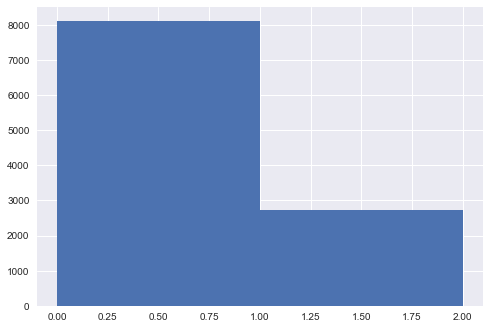

In [9]:
data.Error.hist(bins=[0,1,2])

In [19]:
data.corr()

,Single_Redup,Double_Redup,Triple_Redup,Quad_Redup,Num_Syllables,Year,Round,Times_Used,Years_Since_Last_Used,Error
Single_Redup,1.000000,-0.003688,-0.003336,0.012852,-0.015670,0.016229,0.026725,0.029995,0.010910,0.023164
Double_Redup,-0.003688,1.000000,-0.007067,-0.003748,0.042702,0.016311,0.012175,0.010030,0.013725,0.006799
Triple_Redup,-0.003336,-0.007067,1.000000,-0.001914,0.021602,0.003546,-0.005826,0.006015,0.007903,0.018361
Quad_Redup,0.012852,-0.003748,-0.001914,1.000000,0.024240,0.016117,-0.009646,0.000658,-0.013162,-0.018493
Num_Syllables,-0.015670,0.042702,0.021602,0.024240,1.000000,-0.051258,0.005539,-0.024411,0.024742,0.028150
Year,0.016229,0.016311,0.003546,0.016117,-0.051258,1.000000,0.126289,0.393536,0.394754,-0.174374
Round,0.026725,0.012175,-0.005826,-0.009646,0.005539,0.126289,1.000000,-0.126610,-0.057300,0.034961
Times_Used,0.029995,0.010030,0.006015,0.000658,-0.024411,0.393536,-0.126610,1.000000,0.408115,-0.105268
Years_Since_Last_Used,0.010910,0.013725,0.007903,-0.013162,0.024742,0.394754,-0.057300,0.408115,1.000000,-0.074916
Error,0.023164,0.006799,0.018361,-0.018493,0.028150,-0.174374,0.034961,-0.105268,-0.074916,1.000000


## Create Dummy Variables

In [23]:
#Create Part of Speech Dummy Variables
pos_dum = pd.get_dummies(data.Part_of_Speech, prefix='pos')

pos_dum.drop('pos_noun', axis=1, inplace=True)

data = pd.concat([data, pos_dum], axis=1)

In [24]:
#Create Language Dummy Variables
lang_dum = pd.get_dummies(data.Language, prefix='lang')

lang_dum.drop('lang_Latin', axis=1, inplace=True)

data = pd.concat([data, lang_dum], axis=1)

## Feature Selection

Originally Selected Features:
- Word Length
- Number of Syllables
- Part of Speech
- Levels of Origin
- Times Word Was Used
- Years Since Word Was Last Used
- Year
- Round

**Adjustments:**
- Select one of Word Length and Number of Syllables to avoid collinearity
- Condense Levels of Origin into single Language feature

## Feature Exploration

### Number of Syllables

In [32]:
data.Num_Syllables.describe()

count    10844.000000
mean         3.093231
std          0.953050
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          8.000000
Name: Num_Syllables, dtype: float64

(array([  1.94000000e+02,   2.87100000e+03,   4.39000000e+03,
          2.62300000e+03,   6.66000000e+02,   8.70000000e+01,
          1.10000000e+01,   2.00000000e+00]),
 array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 8 Patch objects>)

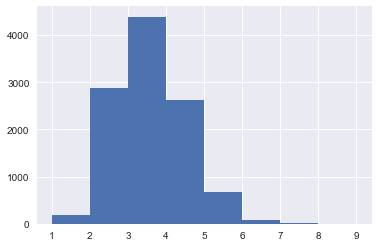

In [33]:
plt.hist(data.Num_Syllables, bins=[1,2,3,4,5,6,7,8,9])

### Part of Speech

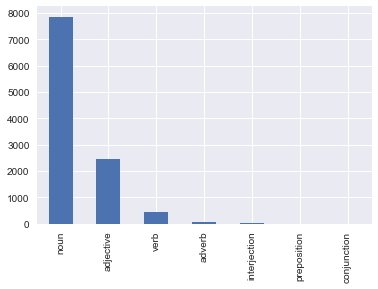

In [35]:
POS = data.Part_of_Speech.value_counts()
POS.plot.bar()

In [36]:
data.Part_of_Speech.value_counts()

noun            7858
adjective       2438
verb             454
adverb            75
interjection      12
preposition        5
conjunction        2
Name: Part_of_Speech, dtype: int64

In [105]:
chi2_contingency(pd.crosstab(data.Part_of_Speech, data.Error))

(9.7586721479508949,
 0.13518967787273842,
 6,
 array([[  1.82377868e+03,   6.14221321e+02],
        [  5.61047584e+01,   1.88952416e+01],
        [  1.49612689e+00,   5.03873110e-01],
        [  8.97676134e+00,   3.02323866e+00],
        [  5.87828255e+03,   1.97971745e+03],
        [  3.74031723e+00,   1.25968277e+00],
        [  3.39620804e+02,   1.14379196e+02]]))

### Language

In [35]:
data.Language.value_counts().shape

(49,)

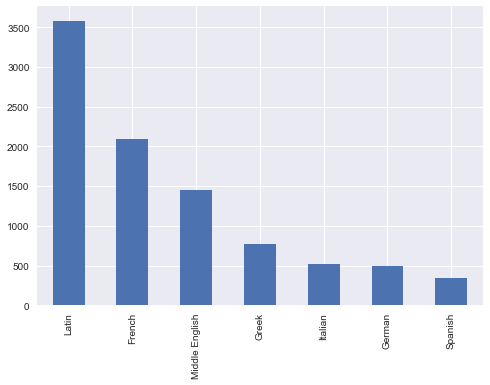

In [31]:
Language_Data = data.groupby("Language").filter(lambda x: len(x) >= 350)
LD = Language_Data.Language.value_counts()
LD.plot.bar()

In [29]:
data.Language.value_counts()

Latin                                  3583
French                                 2088
Middle English                         1450
Greek                                   777
Italian                                 518
German                                  490
Spanish                                 351
Unknown                                 215
International Scientific Vocabulary     212
Germanic (Other)                        176
Japanese                                145
Russian                                 125
Arabic                                   86
Hindi                                    75
Sanskrit                                 64
Proper Name                              63
Portuguese                               56
Austronesian                             50
Celtic                                   40
Hawaiian                                 39
Hebrew                                   34
Balto-Slavic                             30
Sino-Tibetan                    

In [104]:
chi2_contingency(pd.crosstab(data.Language, data.Error))

(82.188908031552614,
 0.0015458029718039075,
 48,
 array([[  4.48838067e+00,   1.51161933e+00],
        [  1.79535227e+01,   6.04647731e+00],
        [  6.43334563e+01,   2.16665437e+01],
        [  7.48063445e-01,   2.51936555e-01],
        [  7.48063445e-01,   2.51936555e-01],
        [  1.42132055e+01,   4.78679454e+00],
        [  3.74031723e+01,   1.25968277e+01],
        [  2.24419034e+01,   7.55809664e+00],
        [  7.48063445e-01,   2.51936555e-01],
        [  1.49612689e+00,   5.03873110e-01],
        [  2.99225378e+01,   1.00774622e+01],
        [  7.48063445e-01,   2.51936555e-01],
        [  4.48838067e+00,   1.51161933e+00],
        [  2.99225378e+00,   1.00774622e+00],
        [  1.56195647e+03,   5.26043526e+02],
        [  7.48063445e-01,   2.51936555e-01],
        [  3.66551088e+02,   1.23448912e+02],
        [  1.31659166e+02,   4.43408336e+01],
        [  7.48063445e-01,   2.51936555e-01],
        [  5.81245297e+02,   1.95754703e+02],
        [  2.91744744e+01,   9

### Times Used

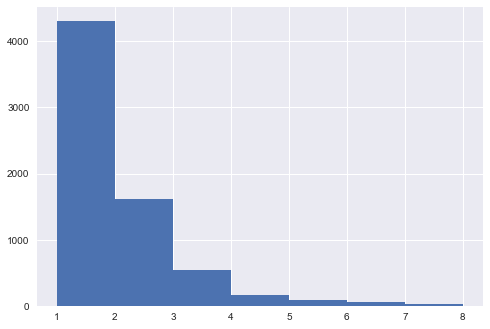

In [5]:
Times_Used_Data = data.groupby('Word').apply(lambda x: x[x.Times_Used==x.Times_Used.max()])
Times_Used_Data.Times_Used.hist(bins=[1,2,3,4,5,6,7,8])

In [58]:
Times_Used_Data.Times_Used.value_counts()

1    4305
2    1620
3     548
4     170
5      81
6      58
7      24
8       7
Name: Times_Used, dtype: int64

In [6]:
Times_Used_Data.Times_Used.skew()

2.4349893460272338

### Years Since Last Used

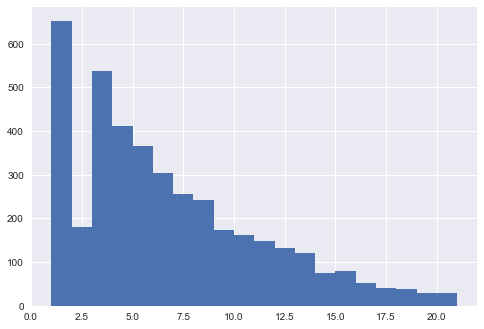

In [67]:
data.Years_Since_Last_Used.hist(bins=range(1,22))

In [71]:
data[data.Years_Since_Last_Used > 0].Years_Since_Last_Used.value_counts()

1.0     652
3.0     538
4.0     412
5.0     366
6.0     304
7.0     257
8.0     243
2.0     181
9.0     174
10.0    162
11.0    149
12.0    132
13.0    122
15.0     79
14.0     76
16.0     53
17.0     41
18.0     38
19.0     29
20.0     24
21.0      5
Name: Years_Since_Last_Used, dtype: int64

In [7]:
data.Years_Since_Last_Used.skew()

1.9828225228935494

### Round

In [99]:
Last_Round = data.groupby('Year').apply(lambda x: x[x.Round==x.Round.max()])
Last_Round.Round.describe()

count    32.000000
mean     16.187500
std       6.869463
min       8.000000
25%      12.000000
50%      15.000000
75%      19.000000
max      39.000000
Name: Round, dtype: float64

In [9]:
data.Round.value_counts().sort_index()

1     1302
2     3606
3     2786
4     1056
5      701
6      454
7      232
8      157
9      116
10      85
11      69
12      51
13      36
14      36
15      27
16      18
17      17
18      14
19      14
20      10
21       7
22       7
23       5
24       2
25       4
26       2
27       3
28       3
29       2
30       4
31       4
32       2
33       1
34       3
35       2
36       1
37       2
38       2
39       1
Name: Round, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x155fda0d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x156a57310>]], dtype=object)

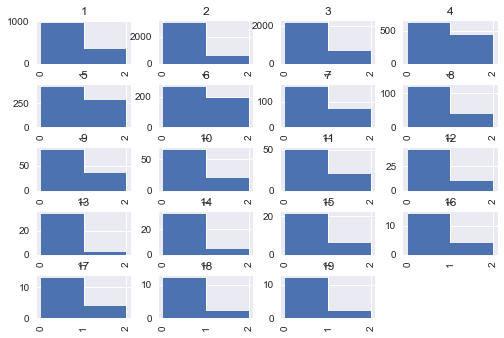

In [93]:
data[data.Round < 20].hist(by='Round', column='Error', bins=[0,1,2])

## Final Correlation Matrices

In [25]:
data.corr().sort_values('Error', ascending=False).head()

,Single_Redup,Double_Redup,Triple_Redup,Quad_Redup,Num_Syllables,Year,Round,Times_Used,Years_Since_Last_Used,Error,...,lang_Sanskrit,lang_Semitic,lang_Sino-Tibetan,lang_Spanish,lang_Tupian,lang_Turkic,lang_Unknown,lang_Uralic,lang_Uto-Aztecan,lang_Wakashan
Error,0.023164,0.006799,0.018361,-0.018493,0.028150,-0.174374,0.034961,-0.105268,-0.074916,1.000000,...,-0.000344,-0.009349,0.008830,0.007886,0.007761,-0.003635,0.013460,-0.009654,-0.011148,0.016548
Round,0.026725,0.012175,-0.005826,-0.009646,0.005539,0.126289,1.000000,-0.126610,-0.057300,0.034961,...,0.015778,0.028779,0.000331,0.006781,-0.002108,-0.003730,-0.004044,0.033405,0.011044,0.001626
Num_Syllables,-0.015670,0.042702,0.021602,0.024240,1.000000,-0.051258,0.005539,-0.024411,0.024742,0.028150,...,-0.044173,-0.029701,-0.049908,0.033503,-0.008455,-0.031664,0.054111,-0.007446,-0.011958,-0.011016
Single_Redup,1.000000,-0.003688,-0.003336,0.012852,-0.015670,0.016229,0.026725,0.029995,0.010910,0.023164,...,-0.026739,0.001469,-0.009009,0.026200,0.010093,-0.015275,-0.013814,-0.008364,-0.009658,0.019101
pos_adverb,0.002404,-0.009817,-0.005014,0.032295,0.040874,-0.017216,0.018460,-0.023999,-0.008373,0.020773,...,-0.006430,-0.002405,-0.003930,-0.015263,-0.001133,-0.002535,0.020059,-0.001388,-0.001603,-0.000801


In [26]:
data.corr().sort_values('Error', ascending=False).tail()

,Single_Redup,Double_Redup,Triple_Redup,Quad_Redup,Num_Syllables,Year,Round,Times_Used,Years_Since_Last_Used,Error,...,lang_Sanskrit,lang_Semitic,lang_Sino-Tibetan,lang_Spanish,lang_Tupian,lang_Turkic,lang_Unknown,lang_Uralic,lang_Uto-Aztecan,lang_Wakashan
lang_Japanese,-0.034523,0.027825,-0.006994,-0.003710,-0.034135,0.049408,-0.002438,0.015486,-0.001392,-0.030572,...,-0.008970,-0.003355,-0.005483,-0.021292,-0.001581,-0.003537,-0.016557,-0.001937,-0.002236,-0.001118
lang_Middle English,-0.019962,-0.006515,-0.010025,-0.012519,-0.130268,-0.062654,-0.088325,-0.060188,-0.006152,-0.037640,...,-0.030272,-0.011323,-0.018503,-0.071856,-0.005336,-0.011936,-0.055877,-0.006536,-0.007547,-0.003773
Years_Since_Last_Used,0.010910,0.013725,0.007903,-0.013162,0.024742,0.394754,-0.057300,0.408115,1.000000,-0.074916,...,-0.009136,-0.013252,-0.000939,-0.005774,-0.007716,-0.006157,0.022449,-0.009450,-0.010912,-0.005455
Times_Used,0.029995,0.010030,0.006015,0.000658,-0.024411,0.393536,-0.126610,1.000000,0.408115,-0.105268,...,0.018331,-0.014153,-0.011020,0.032018,-0.008140,-0.006369,-0.021437,-0.009970,-0.011513,-0.005756
Year,0.016229,0.016311,0.003546,0.016117,-0.051258,1.000000,0.126289,0.393536,0.394754,-0.174374,...,0.037221,0.010408,0.013221,0.034533,-0.000843,0.025886,-0.073833,0.008260,0.017099,0.014035


In [12]:
data.corr()[['Times_Used', 'Years_Since_Last_Used', 'Round']]

,Times_Used,Years_Since_Last_Used,Round
Single_Redup,0.029995,0.010910,0.026725
Double_Redup,0.010030,0.013725,0.012175
Triple_Redup,0.006015,0.007903,-0.005826
Quad_Redup,0.000658,-0.013162,-0.009646
Num_Syllables,-0.024411,0.024742,0.005539
Year,0.393536,0.394754,0.126289
Round,-0.126610,-0.057300,1.000000
Times_Used,1.000000,0.408115,-0.126610
Years_Since_Last_Used,0.408115,1.000000,-0.057300
Error,-0.105268,-0.074916,0.034961


## Next Steps

- Bring in remaining data points
- Determine further adjustments for Language data
- Check features further for collinearity
- Build supervised binary classification model!